In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

from IPython import display
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# BASE_PATH = '/content/drive/Colab Notebooks'
BASE_PATH = '.'
BUFFER_SIZE = 30000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 300
SEED = tf.random.normal([16, NOISE_DIM])

In [3]:
def make_generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))

  model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))

  return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
class Generator(keras.Model):
  def __init__(self, generator, discriminator):
    super(Generator, self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  def train_step(self, data):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    y = tf.ones((BATCH_SIZE, 1))

    with tf.GradientTape() as tape:
      x = self.generator(noise, training=True)
      y_pred = self.discriminator(x, training=False)
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    gradients = tape.gradient(loss, self.generator.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def call(self, x):
    return self.generator(x)

In [6]:
class Discriminator(keras.Model):
  def __init__(self, generator, discriminator):
    super(Discriminator, self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]
    batch_size = tf.shape(real_images)[0]

    noise = tf.random.normal([batch_size, NOISE_DIM])
    generated_images = self.generator(noise, training=False)

    x = tf.concat([real_images, generated_images], axis=0)
    y = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
    # y += 0.05 * tf.random.uniform(tf.shape(y))

    with tf.GradientTape() as tape:
      y_pred = self.discriminator(x, training=True)
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    gradients = tape.gradient(loss, self.discriminator.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def call(self, x):
    return self.discriminator(x)

In [7]:
class CustomCallback(keras.callbacks.Callback):
  def on_train_batch_end(self, batch, logs=None):
    if logs['binary_accuracy'] > 0.9:
      self.model.stop_training = True

In [24]:
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    super(GAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]
    batch_size = tf.shape(real_images)[0]

    noise = tf.random.normal([batch_size, NOISE_DIM])
    generated_images = self.generator(noise, training=False)

    x = tf.concat([real_images, generated_images], axis=0)
    y = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    with tf.GradientTape() as tape:
      y_pred = self.discriminator(x, training=True)
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    gradients = tape.gradient(loss, self.discriminator.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
    self.compiled_metrics.update_state(y, y_pred)
    # self.compiled_metrics.metrics[0].update_state(y, y_pred)

    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    y = tf.ones((BATCH_SIZE, 1))

    with tf.GradientTape() as tape:
      x = self.generator(noise, training=True)
      y_pred = self.discriminator(x, training=False)
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    gradients = tape.gradient(loss, self.generator.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
    # self.compiled_metrics.metrics[1].update_state(y, y_pred)

    return {m.name: m.result() for m in self.metrics}

  def call(self, x):
    return self.generator(x)

In [83]:
def generate_and_save_images(model, epoch, x):
  y = model(x, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(16):
      plt.subplot(4, 4, i+1)
      plt.imshow(y[i, :, :, :])
      plt.axis('off')

  plt.savefig(f'{BASE_PATH}/images/image_at_epoch_{epoch}.png')
  plt.show()

In [9]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

all_digits = np.concatenate([train_images, test_images])
all_digits = np.reshape(all_digits, (-1, 28, 28, 1)).astype("float32")
all_digits = (all_digits) / 255.0

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "cats", label_mode=None, image_size=(64, 64), batch_size=BATCH_SIZE
)

dataset = dataset.map(lambda x: x / 255.0)

Found 15747 files belonging to 1 classes.


In [84]:
generator_model = make_generator_model()
discriminator_model = make_discriminator_model()

generator = Generator(generator_model, discriminator_model)
generator.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()],
    run_eagerly=True
)

discriminator = Discriminator(generator_model, discriminator_model)
discriminator.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()],
    run_eagerly=True
)

gan = GAN(generator_model, discriminator_model)
gan.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy(name='discriminator'), tf.keras.metrics.BinaryAccuracy(name='generator')],
    run_eagerly=True
)

checkpoint_dir = BASE_PATH + '/training_checkpoints'
checkpoint_prefix = checkpoint_dir + '/ckpt'
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

ckptManager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)
ckptManager.restore_or_initialize()

'./training_checkpoints\\ckpt-1'

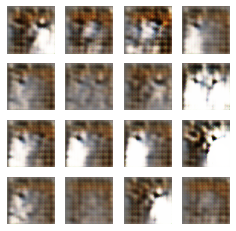

36/62 [================>.............] - ETA: 42s - loss: 0.2775 - discriminator: 0.8679 - generator: 0.8679

KeyboardInterrupt: 

In [86]:
for i in range(50):
  gan.fit(dataset, epochs=1)

  display.clear_output(wait=True)
  generate_and_save_images(model = generator,
                           epoch = i,
                           x = SEED)

  if (i+1) % 25 == 0:
    ckptManager.save()

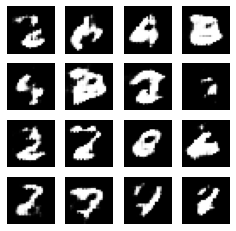

In [20]:
for i in range(50):
  discriminator.fit(dataset, epochs=1)
  generator.fit(dataset, epochs=1)

  display.clear_output(wait=True)
  generate_and_save_images(model = generator,
                           epoch = i,
                           x = SEED)

  # if i+1 % 10 == 0:
  #   ckptManager.save()

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.26924956],
       [-0.28540397],
       [-0.30046445],
       [-0.27180442],
       [-0.24054407]], dtype=float32)>

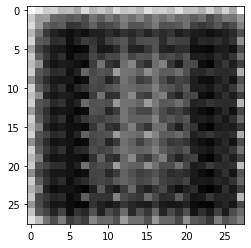

In [14]:
fake = generator(tf.random.normal([5, NOISE_DIM]))
plt.imshow(fake[0, :, :, 0] * 255.0, cmap='gray')
discriminator(fake)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.49406207],
       [1.9187165 ],
       [1.4529849 ],
       [1.7204274 ],
       [0.8376157 ]], dtype=float32)>

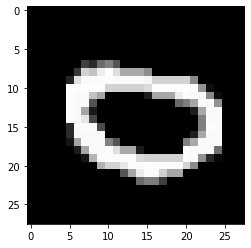

In [15]:
real = train_images[4500:4505]
real = np.reshape(real, (-1, 28, 28, 1)).astype("float32")
real = (real) / 255.0
plt.imshow(real[0, :, :, 0] * 255.0, cmap='gray')
discriminator(real)